In [1]:
%matplotlib inline

import pandas as pd
from sklearn.metrics import auc
import matplotlib.pyplot as plt # standard Python plotting library
import numpy as np  # fundamental package for scientific computing, handles arrays and math
import scipy.signal
from scipy.signal import find_peaks, peak_prominences
import scipy.stats as stats
from scipy.stats import zscore
from pathlib import Path
import tdt # import the tdt library
import seaborn as sns
from matplotlib import rcParams
import os
import numpy as np
import glob
from scipy.signal import find_peaks, peak_prominences, peak_widths

Reading Data/Defining Functions

In [2]:
isosbestic = '_415A'
dopa='_465A'
CHANNEL = 1
TRANGE       = [-5, 10]
BASELINE_PER = [-5, 2]
event_type = 'RNP_'
het_path = r"N:\2024April_May_Tanks_GRBDA_RI\Day4FR1_04272024\HET/*" # path to het folder remember /*
wt_path = r"N:\2024April_May_Tanks_GRBDA_RI\Day4FR1_04272024\WTY/*"
def read_files(path): 
    blockpath = path
    data = tdt.read_block(blockpath, evtype=['epocs','streams'], channel=CHANNEL)
    data = tdt.epoc_filter(data, event_type, t=TRANGE)  #filters the chosen epocs (RNP_) and time set around those epocs
    # More examples of list comprehensions
    min1 = np.min([np.size(x) for x in data['streams'][dopa].filtered])
    min2 = np.min([np.size(x) for x in data['streams'][isosbestic].filtered])
    data['streams'][dopa].filtered = [x[1:min1] for x in data['streams'][dopa].filtered]
    data['streams'][isosbestic].filtered = [x[1:min2] for x in data['streams'][isosbestic].filtered]

    # Downsample and average 10x via a moving window mean
    N = 10 # Average every 10 samples into 1 value
    F415 = []
    F465 = []
    for lst in data['streams'][isosbestic].filtered: 
        small_lst = []
        for i in range(0, min2, N):
            small_lst.append(np.mean(lst[i:i+N-1])) # This is the moving window mean
        F415.append(small_lst)

    for lst in data['streams'][dopa].filtered: 
        small_lst = []
        for i in range(0, min1, N):
            small_lst.append(np.mean(lst[i:i+N-1]))
        F465.append(small_lst)

    #Create a mean signal, standard error of signal, and DC offset
    meanF415 = np.mean(F415, axis=0)
    stdF415 = np.std(F415, axis=0)/np.sqrt(len(data['streams'][isosbestic].filtered))
    dcF415 = np.mean(meanF415)
    meanF465 = np.mean(F465, axis=0)
    stdF465 = np.std(F465, axis=0)/np.sqrt(len(data['streams'][dopa].filtered))
    dcF465 = np.mean(meanF465)
    Y_fit_all = []
    Y_dF_all = []
    for x, y in zip(F415, F465):
        x = np.array(x)
        y = np.array(y)
        bls = np.polyfit(x, y, 1)
        fit_line = np.multiply(bls[0], x) + bls[1]
        Y_fit_all.append(fit_line)
        Y_dF_all.append(y-fit_line)
    ts1 = TRANGE[0] + np.linspace(1, len(meanF465), len(meanF465))/data['streams'][dopa].fs*N
    ts2 = TRANGE[0] + np.linspace(1, len(meanF415), len(meanF415))/data['streams'][isosbestic].fs*N
    # Getting the z-score and standard error
    zall = []
    for dF in Y_dF_all: 
        ind = np.where((np.array(ts2)<BASELINE_PER[1]) & (np.array(ts2)>BASELINE_PER[0]))
        zb = np.mean(dF[ind])
        zsd = np.std(dF[ind])
        zall.append((dF - zb)/zsd)
    ts1 = TRANGE[0] + np.linspace(1, len(meanF465), len(meanF465))/data['streams'][dopa].fs*N
    ts2 = TRANGE[0] + np.linspace(1, len(meanF415), len(meanF415))/data['streams'][isosbestic].fs*N
    #ts1 = ts2 since iso and dopamine are recorded simulteanosuly (I can't spell)
    
    zerror = np.std(zall, axis=0)

    return zall, ts1, ts2, zerror

def T50_measurement(peaks, widths):
    for i in range(len(peaks[0])):
        t50 = (peaks[0][i]-widths[2][i])/(2*101.8) # math for correct time units
    return t50


Appending to lists

In [3]:
h_zavg = [] #het zscore average
h_zste = [] # het zscore standard error
h_ts1 = []
h_ts2 = []
w_zavg = []
w_zste = []
w_ts1 = []
w_ts2 = []
w_ind_z = []
h_ind_z = []

for file in glob.glob(het_path):
    z_ind = read_files(file)
    h_zavg.extend(z_ind[0])
    h_ts1 = z_ind[1]
    h_ts2 = z_ind[2]
    h_ind_z.append(z_ind[0])
    h_zste.append(z_ind[3])
for file in glob.glob(wt_path):
    z_ind = read_files(file)
    w_zavg.extend(z_ind[0])
    w_ts1 = z_ind[1]
    w_ts2 = z_ind[2]
    w_ind_z.append(z_ind[0])
    w_zste.append(z_ind[3])


h_zerror = np.std(h_zavg, axis=0)/np.sqrt(np.size(h_zavg, axis=0)) # standard error of z scores
w_zerror = np.std(w_zavg, axis=0)/np.sqrt(np.size(w_zavg, axis=0))

read from t=0s to t=1865.97s
read from t=0s to t=2405.79s
read from t=0s to t=1511.34s
read from t=0s to t=1230.89s
read from t=0s to t=3150.92s
read from t=0s to t=2537.04s
read from t=0s to t=2077.74s
read from t=0s to t=1354.59s
read from t=0s to t=2311.98s
read from t=0s to t=1532.54s
read from t=0s to t=2083.28s


Peaks

In [4]:
w_peaks = find_peaks(np.mean(w_zavg, axis=0), prominence=1) # wt peak locations, prominence is essentially your threshold of finding peaks
w_peaks_y = [np.mean(w_zavg, axis=0)[i] for i in w_peaks[0]] # wt peak vertex per peak found
w_widths = peak_widths(np.mean(w_zavg, axis=0), w_peaks[0]) # returns: peak widths, contour line of measuring width, left point, right point
w_prominence = peak_prominences(np.mean(w_zavg, axis=0) ,w_peaks[0]) # peak prominence (amplitude replacement), left base, right base (higher of which is contour line)

In [5]:
h_peaks = find_peaks(np.mean(h_zavg, axis=0), prominence=1) 
h_peaks_y = [np.mean(h_zavg, axis=0)[i] for i in h_peaks[0]]
h_widths = peak_widths(np.mean(h_zavg, axis=0), h_peaks[0]) 
h_prominence = peak_prominences(np.mean(h_zavg, axis=0) ,h_peaks[0])

Graphs, all for dopamine

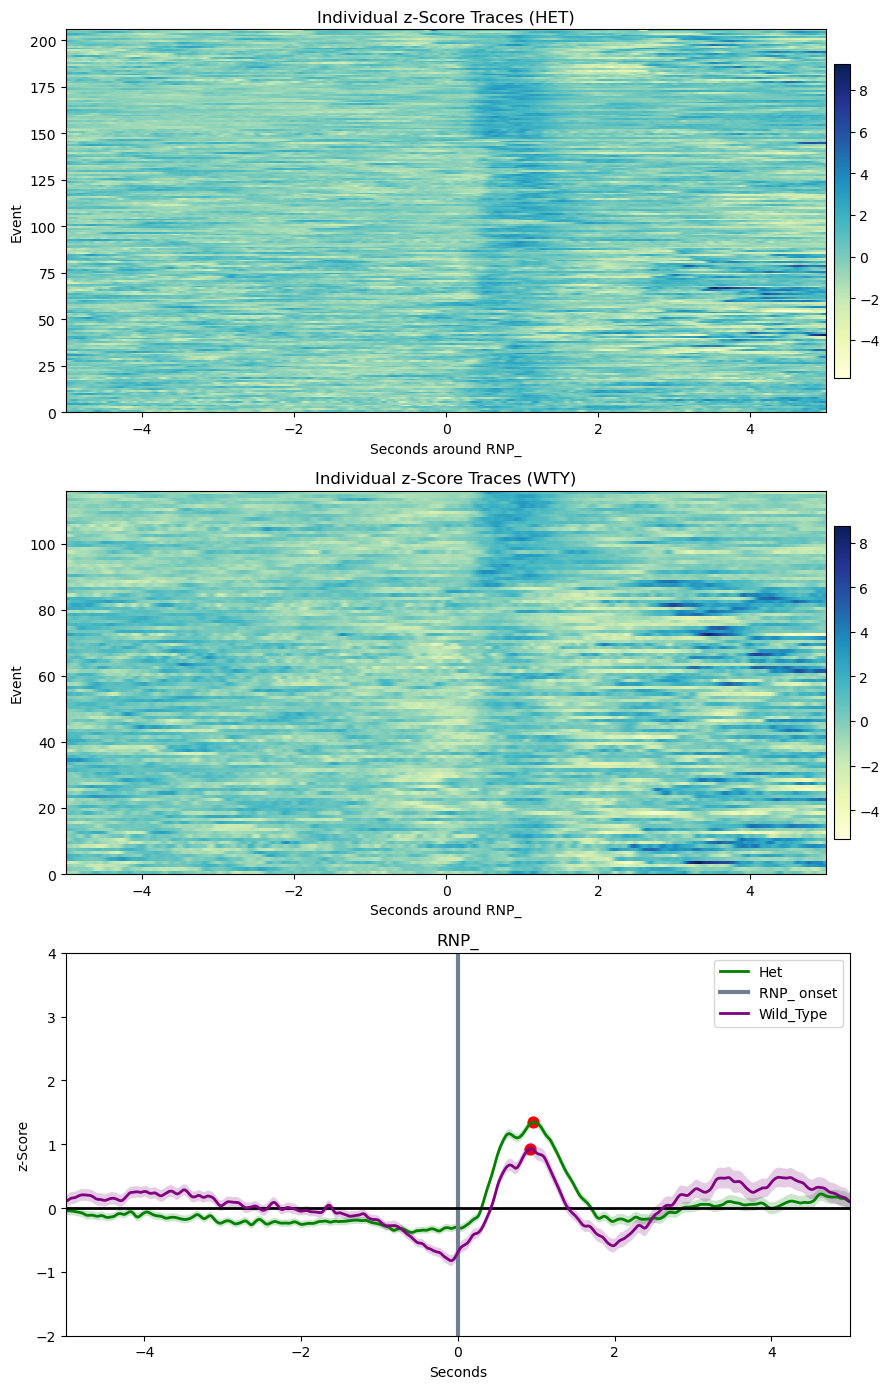

In [6]:
fig = plt.figure(figsize=(9, 14))
ax1 = fig.add_subplot(311) # Het
cs = ax1.imshow(h_zavg, cmap=plt.cm.YlGnBu, interpolation='none', aspect="auto",
                extent=[TRANGE[0], TRANGE[1]+TRANGE[0], 0, len(h_zavg)])
cbar = fig.colorbar(cs, pad=0.01, fraction=0.02)

ax1.set_title('Individual z-Score Traces (HET)') # plot title, add day number
ax1.set_ylabel('Event')
ax1.set_xlabel(f'Seconds around {event_type}')

plt.close() # Suppress figure output again

ax3 = fig.add_subplot(312) # WT
cs3 = ax3.imshow(w_zavg, cmap=plt.cm.YlGnBu, interpolation='none', aspect="auto",
                extent=[TRANGE[0], TRANGE[1]+TRANGE[0], 0, len(w_zavg)])
cbar3 = fig.colorbar(cs3, pad=0.01, fraction=0.02)
ax3.set_title('Individual z-Score Traces (WTY)')
ax3.set_ylabel('Event')
ax3.set_xlabel(f'Seconds around {event_type}')
plt.close()

ax2 = fig.add_subplot(313)
p6 = ax2.plot(h_ts2, np.mean(h_zavg, axis=0), linewidth=2, color='green', label='Het')
p7 = ax2.fill_between(h_ts1, np.mean(h_zavg, axis=0)+h_zerror
                      ,np.mean(h_zavg, axis=0)-h_zerror, facecolor='green', alpha=0.2)
p8 = ax2.axvline(x=0, linewidth=3, color='slategray', label=f'{event_type} onset')
p8 = ax2.axhline(y=0, linewidth=2, color='black')
ax2.set_ylim([-2, 4])
ax2.set_ylabel('z-Score')
ax2.set_xlabel('Seconds')
ax2.set_xlim(TRANGE[0], TRANGE[1]+TRANGE[0])
ax2.set_title(event_type)
ax2.scatter((w_peaks[0]-509)/101, w_peaks_y, s = 60, color="red", marker = "o")
ax2.scatter((h_peaks[0]-509)/101, h_peaks_y, s = 60, color="red", marker = "o")
p9 = ax2.plot(w_ts2, np.mean(w_zavg, axis=0), linewidth=2, color='purple', label='Wild_Type')
p10 = ax2.fill_between(w_ts1, np.mean(w_zavg, axis=0)+w_zerror
                      ,np.mean(w_zavg, axis=0)-w_zerror, facecolor='purple', alpha=0.2)

ax2.legend()

plt.close()
fig.tight_layout()
fig
 #Graph 3
#Graph 2

T50 Slope Analysis, Genotype wise

In [7]:
w_t50 = T50_measurement(w_peaks, w_widths)
h_t50 = T50_measurement(h_peaks,h_widths)
print(f"wt time to half slope {w_t50}; het time to half slope {h_t50}")

wt time to half slope 0.23042525701610742; het time to half slope 0.2608351374131623


In [8]:
h_widths

(array([95.26980001]),
 array([0.56893942]),
 array([552.89396602]),
 array([648.16376604]))

Stats indivudalized per Event


In [9]:
het_df = pd.DataFrame(h_zavg)
wt_df = pd.DataFrame(w_zavg) #create dataframe 

In [10]:
h_zavg_eventwise=(np.array(h_zavg).mean(axis=0)) # muultiple recordings averaged out per frame to get one single array
w_zavg_eventwise=(np.array(w_zavg).mean(axis=0))
ts4 = []
h_trimmed_z_array = []
w_trimmed_z_array = []
for i in range(len(h_ts2)): # since h_ts and w_ts are the same
    if (h_ts2[i] < 2) & (h_ts2[i] > 0): # end and start time values
        ts4.append(h_ts2[i])
        h_trimmed_z_array.append(h_zavg_eventwise[i])
        w_trimmed_z_array.append(w_zavg_eventwise[i])

In [11]:
cols = []
target_trange = []
for i in range(len(h_ts2)): # since h_ts and w_ts are the same
    if (h_ts2[i] > 2) or (h_ts2[i] < 0):
        cols.append(i)
trimmed_het=het_df.drop(het_df.columns[cols], axis = 1)
trimmed_wt = wt_df.drop(wt_df.columns[cols],axis = 1)
trimmed_het.reset_index(drop=True, inplace=True)
trimmed_wt.reset_index(drop=True, inplace=True)
# trims unwanted time range values (set to 0-2 seconds currently)

AUC

In [12]:
trimmed_het

,508,509,510,511,512,513,514,515,516,517,...,702,703,704,705,706,707,708,709,710,711
0,0.712526,0.777153,0.831639,0.879738,0.921278,0.951305,0.965314,0.962133,0.943513,0.913782,...,0.085870,0.057071,0.024986,-0.010253,-0.047262,-0.072076,-0.071834,-0.044137,0.003661,0.054441
1,-0.445368,-0.464619,-0.487226,-0.514474,-0.546937,-0.582343,-0.617318,-0.652072,-0.682146,-0.698251,...,-0.411015,-0.495635,-0.579456,-0.654522,-0.717066,-0.759896,-0.779030,-0.769734,-0.736046,-0.687305
2,0.907424,0.826669,0.750124,0.676810,0.607176,0.545417,0.492037,0.444177,0.398693,0.349089,...,1.385844,1.425333,1.435407,1.423852,1.397503,1.360805,1.323211,1.295856,1.282868,1.283674
3,1.010344,1.090205,1.154111,1.202443,1.236520,1.256519,1.261841,1.253965,1.237239,1.212992,...,-0.637365,-0.687823,-0.736316,-0.780841,-0.814412,-0.831085,-0.828995,-0.807932,-0.771794,-0.724585
4,-0.640888,-0.656708,-0.673494,-0.693765,-0.716779,-0.743821,-0.773534,-0.803570,-0.826550,-0.834746,...,1.644658,1.620345,1.601532,1.590564,1.589356,1.598577,1.616807,1.640841,1.666257,1.690205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,-1.137573,-1.059046,-0.980525,-0.901894,-0.826606,-0.760211,-0.706752,-0.668370,-0.645087,-0.631796,...,-0.030591,-0.072036,-0.131878,-0.198170,-0.264669,-0.326652,-0.376133,-0.410109,-0.419083,-0.402751
202,-0.547650,-0.765484,-1.061642,-1.408443,-1.767885,-2.100230,-2.336395,-2.414586,-2.324228,-2.100012,...,1.297220,1.214728,1.184200,1.206374,1.280846,1.393750,1.519006,1.627057,1.698533,1.720163
203,0.091951,0.081386,0.076731,0.075969,0.079978,0.091335,0.112457,0.144628,0.191058,0.251523,...,2.650481,2.566201,2.477766,2.396010,2.331537,2.286377,2.260023,2.250481,2.254575,2.270026
204,-0.548913,-0.503141,-0.432992,-0.346494,-0.253154,-0.159999,-0.088163,-0.054872,-0.051983,-0.063293,...,1.526555,1.654141,1.773360,1.876545,1.952935,1.992012,1.991573,1.959700,1.900121,1.832815


In [13]:
h_auc_list = []
w_auc_list = []
t_het_array = trimmed_het.to_numpy()
t_wt_array = trimmed_wt.to_numpy()
for i in range(len(t_het_array)):
    h_auc_list.append(auc(ts4,t_het_array[i]))
for i in range(len(t_wt_array)):
    w_auc_list.append(auc(ts4,t_wt_array[i]))
#creates list of auc values per genotype

In [14]:
stats.ranksums(h_auc_list,w_auc_list) #wilcoxon ranked sum test for auc values

RanksumsResult(statistic=5.673331408953612, pvalue=1.400469222428943e-08)

In [15]:
df = pd.DataFrame(w_auc_list)
df.to_clipboard(index=False)

T50

In [16]:
h_t_peaks = []
h_t_widths = []
wt_t_peaks = []
wt_t_widths = []
w_t50_list = []
h_t50_list = []
for i in t_wt_array:
    wpeak = find_peaks(i, prominence= 1)
    wt_t_peaks.append(wpeak)
for i in range(len(wt_t_peaks)):
    wpeakwid = peak_widths(t_wt_array[i], wt_t_peaks[i][0])
    wt_t_widths.append(wpeakwid)
wt_t_peaks[0][0]
for i in range(len(wt_t_widths)):
   t = T50_measurement(wt_t_peaks[i], wt_t_widths[i])
   w_t50_list.append(t)
# w_t50_list

# for i in range(len(wt_t_peaks[i][0])):
#         t50 = (peaks[0][i]-widths[2][i])/(2*101.8)

UnboundLocalError: local variable 't50' referenced before assignment

In [ ]:
w_peaks

(array([603], dtype=int64),
 {'prominences': array([1.53000578]),
  'left_bases': array([499], dtype=int64),
  'right_bases': array([711], dtype=int64)})

In [ ]:
t_w_t50 = T50_measurement(wt_t_peaks, wt_t_widths)
t_h_t50 = T50_measurement(h_t_peaks,h_t_widths)
print(t_w_t50, t_h_t50)

0.22793574550372314 0.2706141629451887


Stats individualized per Animal

1018

In [ ]:
ind_w_df = pd.DataFrame(w_ind_z)
ind_h_df = pd.DataFrame(h_ind_z)

In [ ]:
for i in range(len(h_ts2)): # since h_ts and w_ts are the same
    if (h_ts2[i] < 2) & (h_ts2[i] > 0): # end and start time values
        ts4.append(h_ts2[i])

array([-4.9901696, -4.9803392, -4.9705088, ...,  4.9876862,  4.9975166,
        5.007347 ])